In [32]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy import ndimage, optimize
from scipy.fft import fft2, ifft2
import cv2

import beam_caustic

In [33]:
pixel_array = np.loadtxt('drop4photo1.txt', dtype=np.uint8, delimiter=None, skiprows=3)

print(pixel_array.shape)


(492, 384)


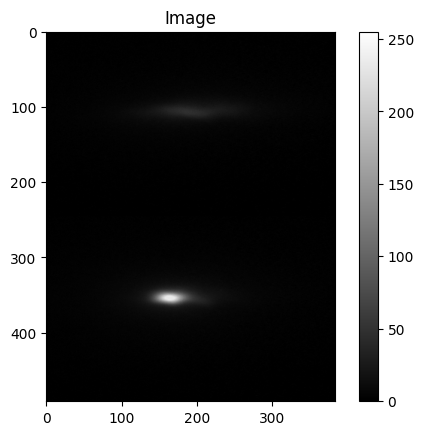

In [34]:
plt.imshow(pixel_array, cmap='gray', vmin=0, vmax=255) # Use 'gray' colormap for grayscale
plt.colorbar() # Add a color bar to show value range
plt.title('Image')
plt.show()


In [35]:
y_start = int((492/2)+1)
y_end = 492

before_shutter = pixel_array[y_start:y_end-1, 0:384]

print(before_shutter.shape)

(244, 384)


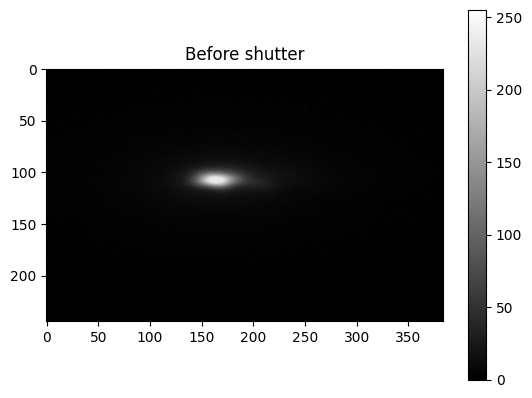

In [36]:
plt.imshow(before_shutter, cmap='gray', vmin=0, vmax=255) # Use 'gray' colormap for grayscale
plt.colorbar() # Add a color bar to show value range
plt.title('Before shutter')
plt.show()

In [65]:
# ccd analysis

# Default values
# Relative tolerance condition for convergence of D4σ method
d4s_rel_tol = 1e-5
# Absolute tolerance condition for convergence of D4σ method
d4s_abs_tol = 1e-2
# Save plots
save_plots = True

# Pixel size of images (mm)
pixel_size_x = 8.4e-3
pixel_size_y = 9.8e-6
d4s_rel_tol = None
d4s_abs_tol = 1

# Scaling factor for ellipse to be used for background subtraction
bkg_ellipse_axes_scaling = 1
# Self-confined width of D4σ method
self_conf_width = 3

waists_x = []
waists_y = []

d4sigma_dicts = []

gaussian_fits = []

Results from moments of non-background-corrected image (x0, y0, D4σx, D4σy, phi): 1.77e+02 px, 1.08e+02 px, 2.98e+02 px, 1.56e+02 px, -0.47 deg

Results from ellipse fit (x0, y0, minor semi axis, major semi axis, phi): 1.65e+02 px, 1.07e+02 px, 1.69e+01 px, 4.75e+01 px, -0.13 deg
Image mean, SD, SEM, max (cts/px): 4.3e+00, 1.3e+01, 4.4e-02, 2.4e+02
Background mean, SD, SEM, max (cts/px): 2.7e+00, 3.0e+00, 9.8e-03, 3.2e+01
Mean background/peak image: 1.2e-02
Results from moments of background-corrected image (x0, y0, D4σx, D4σy, phi): 1.51e+02 px, 8.34e+01 px, nan px, nan px, 24.42 deg



/Users/nadiathesun/Downloads/adinadia12826 MOT data/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Results of 2D Gaussian fit with free orientation (x0, y0, D4σx, D4σy, phi):
1.65e+02 px, 1.07e+02 px, 6.767e+01 px, 2.426e+01 px, 0.15 deg

1/e^2 radius from 2D Gaussian fit: major/minor/simple average:
2.842e-01 mm/1.189e-04 mm/1.422e-01 mm
Results from ellipse fit to determine start values for D4σ method (x0, y0, minor semi axis, major semi axis, phi): 2.03e+02 px, 2.47e+02 px, 1.69e+02 px, 7.30e+02 px, -4.01 deg
Using ellipse center and major semi axis as start values for D4σ method
Iteration 1:
[150.92870528  83.40401854          nan          nan]
Iteration 2:
Error: Unable to determine beam parameters using moments, stopping

Results of D4σ method (x0, y0, D4σx, D4σy, phi): 1.51e+02 px, 8.34e+01 px, nan px, nan px, 24.42 deg


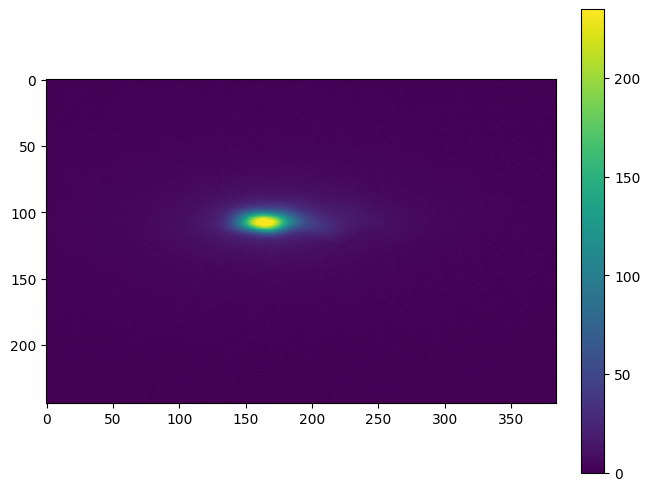

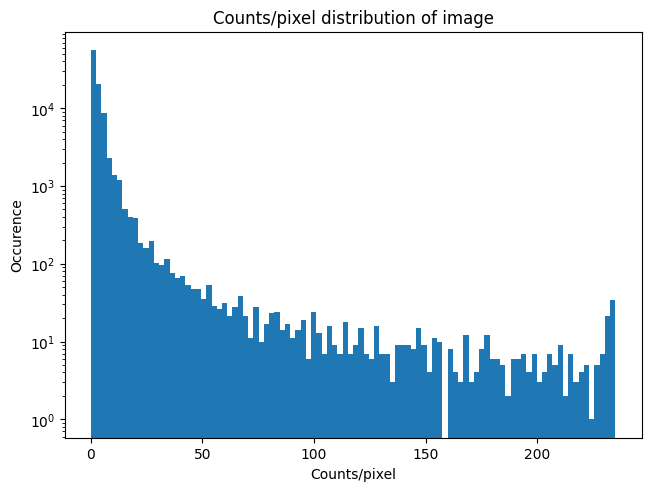

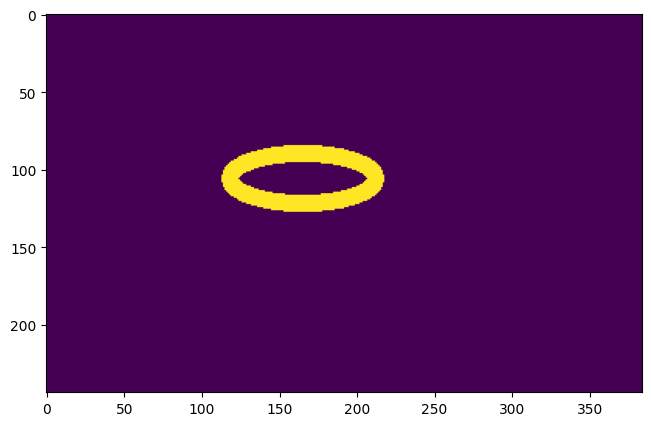

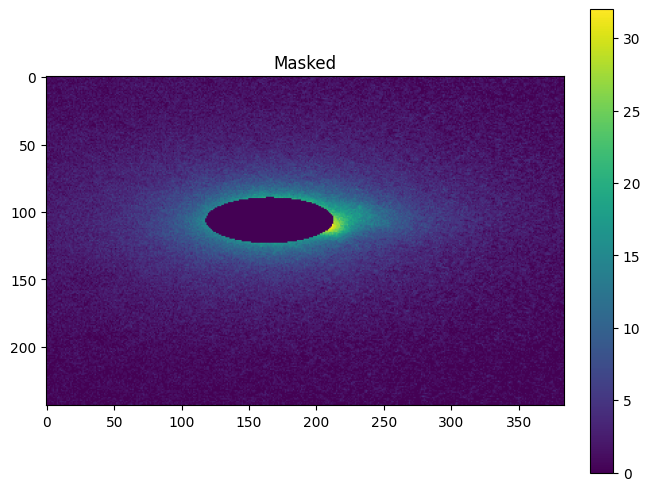

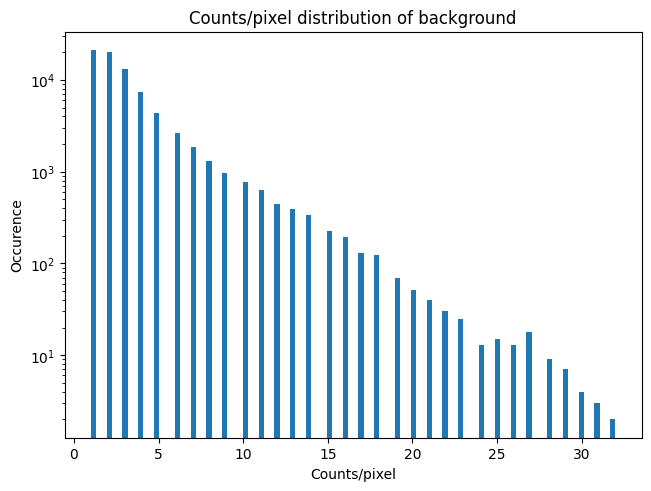

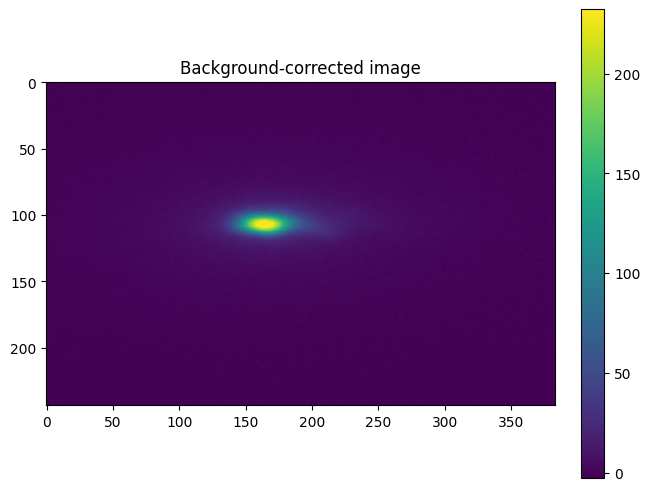

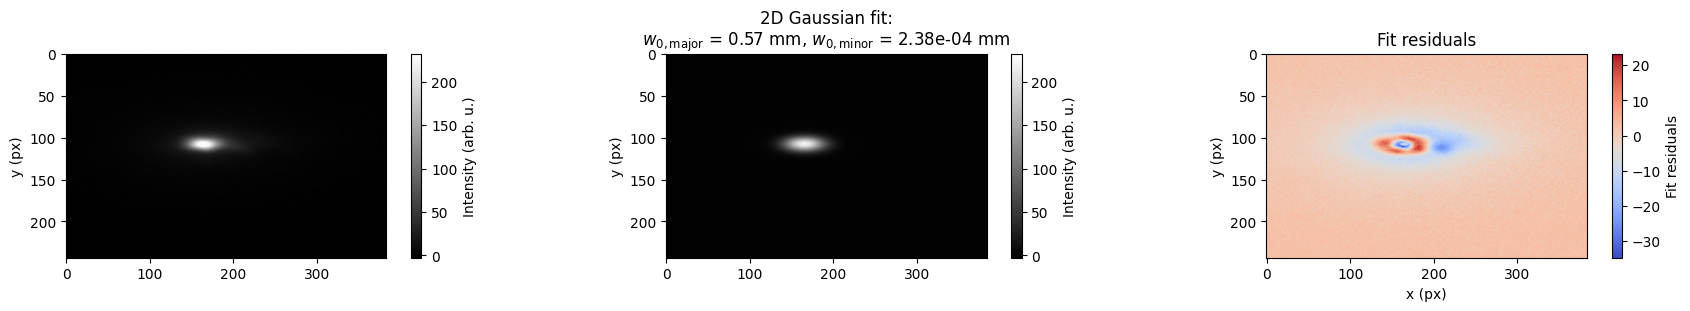

In [66]:


# Plot image
fig_im = plt.figure('Image', clear=True, constrained_layout=True)
ax_im = fig_im.gca()
h = ax_im.imshow(before_shutter)
plt.colorbar(h)

fig_hist = plt.figure('Histogram', clear=True, constrained_layout=True)
ax_hist = fig_hist.gca()
h = ax_hist.hist(before_shutter.ravel(), bins=100, log=True)
ax_hist.set_title(f'Counts/pixel distribution of image')
ax_hist.set_xlabel('Counts/pixel')
ax_hist.set_ylabel('Occurence')



# Determine ISO beam parameters from image before correcting for background.
# If there is a background present, this will give erroneous results for the beam width.
xc_iso_wbkg, yc_iso_wbkg, dx_iso_wbkg, dy_iso_wbkg, orientation_iso_wbkg = (
    beam_caustic.determine_iso_beam_parameters(before_shutter, fixed_orientation=None))
print(
    'Results from moments of non-background-corrected image (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_iso_wbkg:.2e} px, {yc_iso_wbkg:.2e} px, {dx_iso_wbkg:.2e} px, {dy_iso_wbkg:.2e} px'
    +f', {orientation_iso_wbkg:.2f} deg')

print('')

# Find ellipse for background subtraction
xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell = (
    beam_caustic.find_ellipse(before_shutter))
print(
    'Results from ellipse fit (x0, y0, minor semi axis, major semi axis, phi): '
    +f'{xc_ell:.2e} px, {yc_ell:.2e} px, {minor_saxis_ell:.2e} px, {major_saxis_ell:.2e} px'
    +f', {orientation_ell:.2f} deg')

# Show ellipse
image_blank = np.zeros(before_shutter.shape)
image_ellipse = cv2.ellipse(
    image_blank,
    (int(xc_ell), int(yc_ell)), (int(minor_saxis_ell), int(major_saxis_ell)),
    orientation_ell+90, 0, 360, 1, 10)
plt.figure('Ellipse', clear=True, constrained_layout=True)
plt.imshow(image_ellipse)



# Find mask matching ellipse, scaled in size by factor `bkg_ellipse_axes_scaling`
ellipse_mask = beam_caustic.get_ellipse_mask(
    xc_ell, yc_ell,
    bkg_ellipse_axes_scaling*minor_saxis_ell, bkg_ellipse_axes_scaling*major_saxis_ell,
    orientation_ell, before_shutter.shape)

# Show ellipse mask
image_masked = before_shutter.copy()
image_masked[ellipse_mask] = 0
# image_masked[image_masked < 5000] = 0
fig_masked = plt.figure('Masked', clear=True, constrained_layout=True)
ax_masked = fig_masked.gca()
h = ax_masked.imshow(image_masked)
ax_masked.set_title('Masked')
plt.colorbar(h)

fig_hist_bkg = plt.figure('Histogram of background', clear=True, constrained_layout=True)
ax_hist_bkg = fig_hist_bkg.gca()
h = ax_hist_bkg.hist(image_masked[image_masked > 0].ravel(), bins=100, log=True)
ax_hist_bkg.set_title(f'Counts/pixel distribution of background')
ax_hist_bkg.set_xlabel('Counts/pixel')
ax_hist_bkg.set_ylabel('Occurence')

im_max = before_shutter.max()
im_avg = before_shutter.mean()
im_std = before_shutter.std()
im_err = im_std/np.sqrt(before_shutter.size)
print(
    'Image mean, SD, SEM, max (cts/px):'
    +f' {im_avg:.1e}, {im_std:.1e}, {im_err:.1e}, {im_max:.1e}')

# Use area outside scaled ellipse to estimate background
if len(before_shutter[~ellipse_mask]) != 0:
    bkg_max = before_shutter[~ellipse_mask].max()
    bkg_avg = before_shutter[~ellipse_mask].mean()
    bkg_std = before_shutter[~ellipse_mask].std()
    bkg_err = bkg_std/np.sqrt(np.sum(~ellipse_mask))
    print(
        'Background mean, SD, SEM, max (cts/px):'
        +f' {bkg_avg:.1e}, {bkg_std:.1e}, {bkg_err:.1e}, {bkg_max:.1e}')
    print(f'Mean background/peak image: {bkg_avg/before_shutter.max():.1e}')
else:
    print('No pixels outside scaled ellipse left to estimate background from')

# Subtract average background from image
# image_bkg_corr = image
image_bkg_corr = before_shutter-bkg_avg
# image_bkg_corr[image_bkg_corr < 0] = 0.

# Plot background-corrected image
fig_bkg_corr = plt.figure('Background-corrected image', clear=True, constrained_layout=True)
ax_bkg_corr = fig_bkg_corr.gca()
h = ax_bkg_corr.imshow(image_bkg_corr)
ax_bkg_corr.set_title('Background-corrected image')
plt.colorbar(h)



# Determine ISO beam parameters from background-corrected image
xc_iso, yc_iso, dx_iso, dy_iso, orientation_iso = beam_caustic.determine_iso_beam_parameters(
    image_bkg_corr, fixed_orientation=None)
print(
    'Results from moments of background-corrected image (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_iso:.2e} px, {yc_iso:.2e} px, {dx_iso:.3e} px, {dy_iso:.3e} px'
    +f', {orientation_iso:.2f} deg')
print('')

# Fit 2D Gaussian with free orientation
fit_result, fit_dict, gaussian_2d = beam_caustic.fit_gaussian_2d(
    image_bkg_corr,
    pstart=[
        image_bkg_corr.max(),
        xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell,
        0.])
print(
    'Results of 2D Gaussian fit with free orientation (x0, y0, D4σx, D4σy, phi):\n'
    +f'{fit_dict["x0_Value"]:.2e} px, {fit_dict["y0_Value"]:.2e} px'
    +f', {2*fit_dict["w0x_Value"]:.3e} px, {2*fit_dict["w0y_Value"]:.3e} px'
    +f', {fit_dict["Orientation_Value"]:.2f} deg')
print('')

print(
    '1/e^2 radius from 2D Gaussian fit: major/minor/simple average:\n'
    +f'{pixel_size_x*fit_dict["w0x_Value"]:.3e} mm/{pixel_size_y*fit_dict["w0y_Value"]:.3e} mm'
    +f'/{np.mean([pixel_size_x*fit_dict["w0x_Value"], pixel_size_y*fit_dict["w0y_Value"]]):.3e} mm'
    )
beam_center = [fit_dict["x0_Value"], fit_dict["y0_Value"]]
beam_center_px = np.round(beam_center).astype(int)



# D4σ method
xc_d4s, yc_d4s, dx_d4s, dy_d4s, orientation_d4s, iterations_d4s, converged_d4s = (
    beam_caustic.run_d4sigma_method(
        image_bkg_corr, self_conf_width=self_conf_width, debug=True,
        ignore_crop_error=True,
        rel_tol=d4s_rel_tol, abs_tol=d4s_abs_tol,
        # start_values=[xc_ell, yc_ell, major_saxis_ell, major_saxis_ell],
        ))
print('')
print(
    'Results of D4σ method (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_d4s:.2e} px, {yc_d4s:.2e} px, {dx_d4s:.3e} px, {dy_d4s:.3e} px'
    +f', {orientation_d4s:.2f} deg')



#%% Plot results of 2D Gaussian fit

fig_2dgauss, axs_2dgauss = plt.subplots(
    1, 3, num='2D Gaussian fit', figsize=(18, 3), clear=True, constrained_layout=True)
image_fit = gaussian_2d(*fit_result['Popt'])(*np.flipud(np.indices(image_bkg_corr.shape)))

for (ax, im_, im_cmap, label, cmap) in zip(
        axs_2dgauss,
        [image_bkg_corr, image_fit, (image_fit-image_bkg_corr)],
        [image_bkg_corr, image_bkg_corr, None],
        ['Intensity (arb. u.)', 'Intensity (arb. u.)', 'Fit residuals'],
        ['gray', 'gray', 'coolwarm']
        ):

    h_im = ax.imshow(
        im_,
        cmap=cmap,
        vmin=im_cmap.min() if im_cmap is not None else None,
        vmax=im_cmap.max() if im_cmap is not None else None,
        )
    ax.set_ylabel('y (px)')
    h_cbar = plt.colorbar(h_im, ax=ax)
    h_cbar.set_label(label)

axs_2dgauss[1].set_title(
    '2D Gaussian fit:\n'
    +rf'$w_{{0,\mathrm{{major}}}}$ = {fit_dict["w0x_Value"]*2*pixel_size_x:.2f} mm'
    +rf', $w_{{0,\mathrm{{minor}}}}$ = {fit_dict["w0y_Value"]*2*pixel_size_y:.2e} mm'
    )
axs_2dgauss[2].set_title('Fit residuals')
axs_2dgauss[-1].set_xlabel('x (px)')

if save_plots:
    fig_2dgauss.savefig('_2dgauss.png')


waists_x.append(fit_dict["w0x_Value"]*2*pixel_size_x)
waists_y.append(fit_dict["w0y_Value"]*2*pixel_size_y)

d4sigma_dicts.append(fit_dict)

gaussian_fits.append(image_fit)


(244, 384)


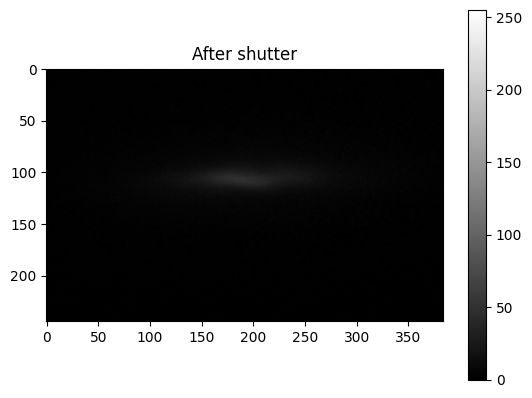

In [67]:
y_start1 = 0
y_end1 =  int((492/2)-1)

after_shutter = pixel_array[y_start1:y_end1-1, 0:384]

print(after_shutter.shape)


plt.imshow(after_shutter, cmap='gray', vmin=0, vmax=255) # Use 'gray' colormap for grayscale
plt.colorbar() # Add a color bar to show value range
plt.title('After shutter')
plt.show()

Results from moments of non-background-corrected image (x0, y0, D4σx, D4σy, phi): 1.94e+02 px, 1.07e+02 px, 3.42e+02 px, 1.63e+02 px, -1.78 deg

Results from ellipse fit (x0, y0, minor semi axis, major semi axis, phi): 1.95e+02 px, 1.05e+02 px, 2.93e+01 px, 1.58e+02 px, -1.68 deg
Image mean, SD, SEM, max (cts/px): 2.9e+00, 4.9e+00, 1.6e-02, 5.0e+01
Background mean, SD, SEM, max (cts/px): 1.5e+00, 1.3e+00, 4.6e-03, 8.0e+00
Mean background/peak image: 2.9e-02
Results from moments of background-corrected image (x0, y0, D4σx, D4σy, phi): 1.97e+02 px, 9.15e+01 px, 1.889e+02 px, nan px, -3.59 deg



/Users/nadiathesun/Downloads/adinadia12826 MOT data/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Results of 2D Gaussian fit with free orientation (x0, y0, D4σx, D4σy, phi):
1.94e+02 px, 1.06e+02 px, 2.190e+02 px, 4.322e+01 px, -1.39 deg

1/e^2 radius from 2D Gaussian fit: major/minor/simple average:
1.840e+00 mm/4.235e-04 mm/9.201e-01 mm
Results from ellipse fit to determine start values for D4σ method (x0, y0, minor semi axis, major semi axis, phi): 1.48e+02 px, -8.78e+01 px, 2.76e+02 px, 7.67e+02 px, -5.11 deg
Using ellipse center and major semi axis as start values for D4σ method
Iteration 1:
[196.8474079   91.53036551 188.12831086          nan]
Iteration 2:
Error: Unable to determine beam parameters using moments, stopping

Results of D4σ method (x0, y0, D4σx, D4σy, phi): 1.97e+02 px, 9.15e+01 px, 1.881e+02 px, nan px, -3.59 deg


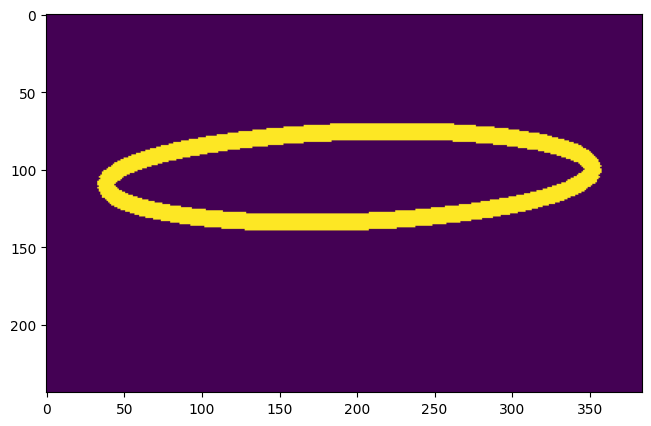

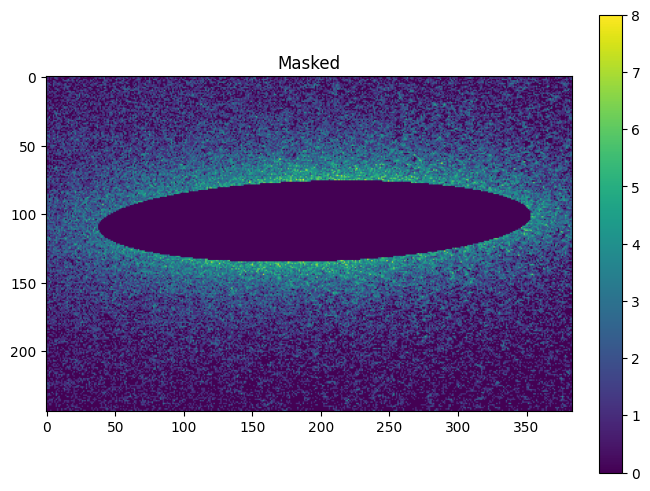

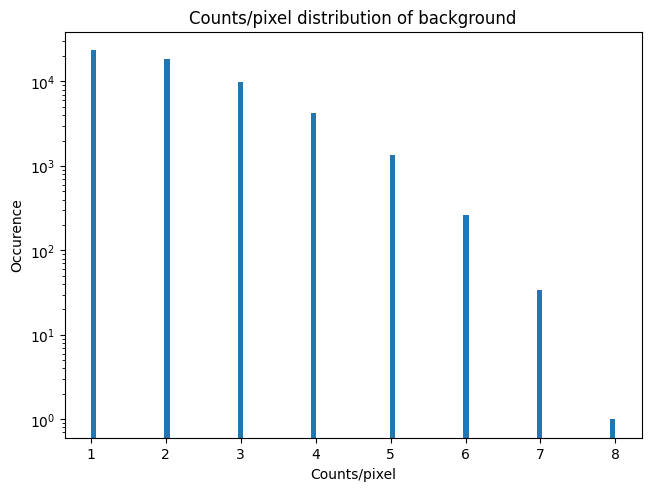

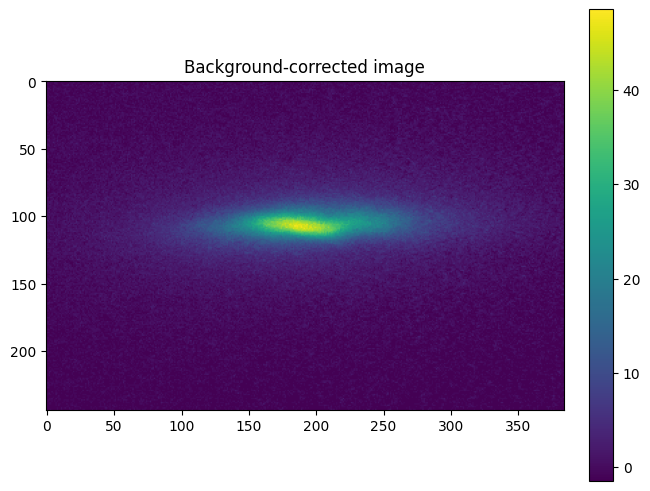

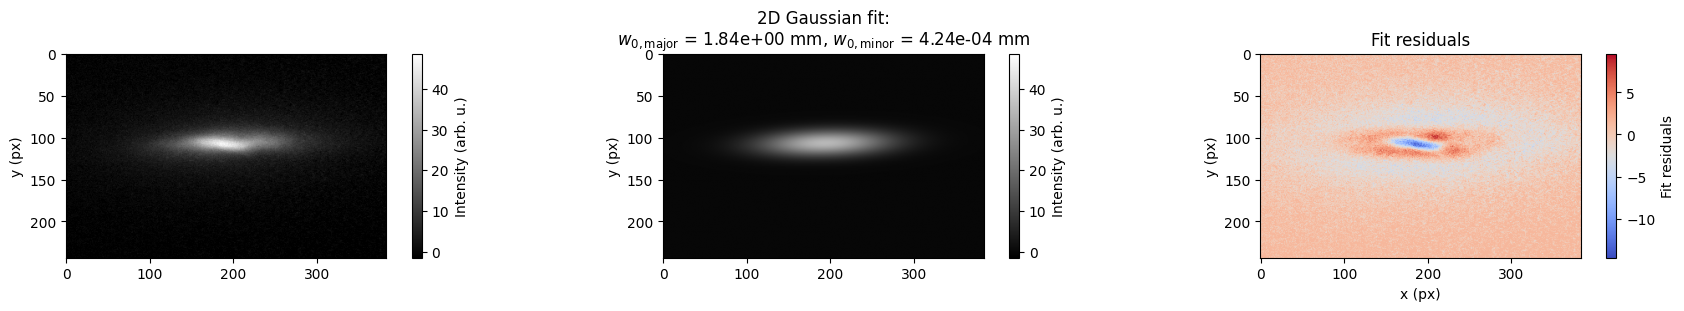

In [68]:
# Determine ISO beam parameters from image before correcting for background.
# If there is a background present, this will give erroneous results for the beam width.
xc_iso_wbkg, yc_iso_wbkg, dx_iso_wbkg, dy_iso_wbkg, orientation_iso_wbkg = (
    beam_caustic.determine_iso_beam_parameters(after_shutter, fixed_orientation=None))
print(
    'Results from moments of non-background-corrected image (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_iso_wbkg:.2e} px, {yc_iso_wbkg:.2e} px, {dx_iso_wbkg:.2e} px, {dy_iso_wbkg:.2e} px'
    +f', {orientation_iso_wbkg:.2f} deg')

print('')

# Find ellipse for background subtraction
xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell = (
    beam_caustic.find_ellipse(after_shutter))
print(
    'Results from ellipse fit (x0, y0, minor semi axis, major semi axis, phi): '
    +f'{xc_ell:.2e} px, {yc_ell:.2e} px, {minor_saxis_ell:.2e} px, {major_saxis_ell:.2e} px'
    +f', {orientation_ell:.2f} deg')

# Show ellipse
image_blank = np.zeros(after_shutter.shape)
image_ellipse = cv2.ellipse(
    image_blank,
    (int(xc_ell), int(yc_ell)), (int(minor_saxis_ell), int(major_saxis_ell)),
    orientation_ell+90, 0, 360, 1, 10)
plt.figure('Ellipse', clear=True, constrained_layout=True)
plt.imshow(image_ellipse)


# Find mask matching ellipse, scaled in size by factor `bkg_ellipse_axes_scaling`
ellipse_mask = beam_caustic.get_ellipse_mask(
    xc_ell, yc_ell,
    bkg_ellipse_axes_scaling*minor_saxis_ell, bkg_ellipse_axes_scaling*major_saxis_ell,
    orientation_ell, after_shutter.shape)

# Show ellipse mask
image_masked = after_shutter.copy()
image_masked[ellipse_mask] = 0
# image_masked[image_masked < 5000] = 0
fig_masked = plt.figure('Masked', clear=True, constrained_layout=True)
ax_masked = fig_masked.gca()
h = ax_masked.imshow(image_masked)
ax_masked.set_title('Masked')
plt.colorbar(h)

fig_hist_bkg = plt.figure('Histogram of background', clear=True, constrained_layout=True)
ax_hist_bkg = fig_hist_bkg.gca()
h = ax_hist_bkg.hist(image_masked[image_masked > 0].ravel(), bins=100, log=True)
ax_hist_bkg.set_title(f'Counts/pixel distribution of background')
ax_hist_bkg.set_xlabel('Counts/pixel')
ax_hist_bkg.set_ylabel('Occurence')

im_max = after_shutter.max()
im_avg = after_shutter.mean()
im_std = after_shutter.std()
im_err = im_std/np.sqrt(after_shutter.size)
print(
    'Image mean, SD, SEM, max (cts/px):'
    +f' {im_avg:.1e}, {im_std:.1e}, {im_err:.1e}, {im_max:.1e}')

# Use area outside scaled ellipse to estimate background
if len(after_shutter[~ellipse_mask]) != 0:
    bkg_max = after_shutter[~ellipse_mask].max()
    bkg_avg = after_shutter[~ellipse_mask].mean()
    bkg_std = after_shutter[~ellipse_mask].std()
    bkg_err = bkg_std/np.sqrt(np.sum(~ellipse_mask))
    print(
        'Background mean, SD, SEM, max (cts/px):'
        +f' {bkg_avg:.1e}, {bkg_std:.1e}, {bkg_err:.1e}, {bkg_max:.1e}')
    print(f'Mean background/peak image: {bkg_avg/after_shutter.max():.1e}')
else:
    print('No pixels outside scaled ellipse left to estimate background from')

# Subtract average background from image
# image_bkg_corr = image
image_bkg_corr = after_shutter-bkg_avg
# image_bkg_corr[image_bkg_corr < 0] = 0.

# Plot background-corrected image
fig_bkg_corr = plt.figure('Background-corrected image', clear=True, constrained_layout=True)
ax_bkg_corr = fig_bkg_corr.gca()
h = ax_bkg_corr.imshow(image_bkg_corr)
ax_bkg_corr.set_title('Background-corrected image')
plt.colorbar(h)

# Determine ISO beam parameters from background-corrected image
xc_iso, yc_iso, dx_iso, dy_iso, orientation_iso = beam_caustic.determine_iso_beam_parameters(
    image_bkg_corr, fixed_orientation=None)
print(
    'Results from moments of background-corrected image (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_iso:.2e} px, {yc_iso:.2e} px, {dx_iso:.3e} px, {dy_iso:.3e} px'
    +f', {orientation_iso:.2f} deg')
print('')

# Fit 2D Gaussian with free orientation
fit_result, fit_dict, gaussian_2d = beam_caustic.fit_gaussian_2d(
    image_bkg_corr,
    pstart=[
        image_bkg_corr.max(),
        xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell,
        0.])
print(
    'Results of 2D Gaussian fit with free orientation (x0, y0, D4σx, D4σy, phi):\n'
    +f'{fit_dict["x0_Value"]:.2e} px, {fit_dict["y0_Value"]:.2e} px'
    +f', {2*fit_dict["w0x_Value"]:.3e} px, {2*fit_dict["w0y_Value"]:.3e} px'
    +f', {fit_dict["Orientation_Value"]:.2f} deg')
print('')

print(
    '1/e^2 radius from 2D Gaussian fit: major/minor/simple average:\n'
    +f'{2*pixel_size_x*fit_dict["w0x_Value"]:.3e} mm/{2*pixel_size_y*fit_dict["w0y_Value"]:.3e} mm'
    +f'/{np.mean([2*pixel_size_x*fit_dict["w0x_Value"], 2*pixel_size_y*fit_dict["w0y_Value"]]):.3e} mm'
    )
beam_center = [fit_dict["x0_Value"], fit_dict["y0_Value"]]
beam_center_px = np.round(beam_center).astype(int)

# D4σ method
xc_d4s, yc_d4s, dx_d4s, dy_d4s, orientation_d4s, iterations_d4s, converged_d4s = (
    beam_caustic.run_d4sigma_method(
        image_bkg_corr, self_conf_width=self_conf_width, debug=True,
        ignore_crop_error=True,
        rel_tol=d4s_rel_tol, abs_tol=d4s_abs_tol,
        # start_values=[xc_ell, yc_ell, major_saxis_ell, major_saxis_ell],
        ))
print('')
print(
    'Results of D4σ method (x0, y0, D4σx, D4σy, phi): '
    +f'{xc_d4s:.2e} px, {yc_d4s:.2e} px, {dx_d4s:.3e} px, {dy_d4s:.3e} px'
    +f', {orientation_d4s:.2f} deg')

#%% Plot results of 2D Gaussian fit

fig_2dgauss, axs_2dgauss = plt.subplots(
    1, 3, num='2D Gaussian fit', figsize=(18, 3), clear=True, constrained_layout=True)
image_fit = gaussian_2d(*fit_result['Popt'])(*np.flipud(np.indices(image_bkg_corr.shape)))

for (ax, im_, im_cmap, label, cmap) in zip(
        axs_2dgauss,
        [image_bkg_corr, image_fit, (image_fit-image_bkg_corr)],
        [image_bkg_corr, image_bkg_corr, None],
        ['Intensity (arb. u.)', 'Intensity (arb. u.)', 'Fit residuals'],
        ['gray', 'gray', 'coolwarm']
        ):

    h_im = ax.imshow(
        im_,
        cmap=cmap,
        vmin=im_cmap.min() if im_cmap is not None else None,
        vmax=im_cmap.max() if im_cmap is not None else None,
        )
    ax.set_ylabel('y (px)')
    h_cbar = plt.colorbar(h_im, ax=ax)
    h_cbar.set_label(label)

axs_2dgauss[1].set_title(
    '2D Gaussian fit:\n'
    +rf'$w_{{0,\mathrm{{major}}}}$ = {fit_dict["w0x_Value"]*2*pixel_size_x:.2e} mm'
    +rf', $w_{{0,\mathrm{{minor}}}}$ = {fit_dict["w0y_Value"]*2*pixel_size_y:.2e} mm'
    )
axs_2dgauss[2].set_title('Fit residuals')
axs_2dgauss[-1].set_xlabel('x (px)')

if save_plots:
    fig_2dgauss.savefig('_2dgauss.png')


waists_x.append(fit_dict["w0x_Value"]*2*pixel_size_x)
waists_y.append(fit_dict["w0y_Value"]*2*pixel_size_y)


d4sigma_dicts.append(fit_dict)

gaussian_fits.append(image_fit)


# Atom Number

In [52]:
print(waists_x)
print(waists_y)

print(d4sigma_dicts)

[np.float64(0.5684635848916054), np.float64(1.8398472903755527)]
[np.float64(0.00023771902375169975), np.float64(0.00042352006461898663)]
[{'Amplitude_Value': np.float64(222.2942055667546), 'Amplitude_Sigma': np.float64(0.07877250215329476), 'x0_Value': np.float64(165.2015976284041), 'x0_Sigma': np.float64(0.005995103257350107), 'y0_Value': np.float64(107.03229200221132), 'y0_Sigma': np.float64(0.002148947715134213), 'w0x_Value': np.float64(33.83711814830985), 'w0x_Sigma': np.float64(0.012032580960108013), 'w0y_Value': np.float64(12.128521619984681), 'w0y_Sigma': np.float64(0.004312969822969493), 'ChiSq': np.float64(1020677.4659407845), 'RedChiSq': np.float64(10.89431487091104), 'Error': False, 'Orientation_Value': np.float64(0.15110728374071694), 'Orientation_Sigma': np.float64(0.011809177173871461), 'Offset_Value': np.float64(0.030847191780772495), 'Offset_Sigma': np.float64(0.0033128300432912045)}, {'Amplitude_Value': np.float64(34.52880582873495), 'Amplitude_Sigma': np.float64(0.03

In [71]:
before_shutter_integral = np.sum(gaussian_fits[0])
after_shutter_integral = np.sum(gaussian_fits[1])

print(before_shutter_integral)
print(after_shutter_integral)

146191.26929781103
133522.4345155602


# Temperature

In [72]:
tof = 10e-3

x_init = d4sigma_dicts[0]['x0_Value'] * 1e-3
x_final = d4sigma_dicts[1]['x0_Value'] * 1e-3

y_init = d4sigma_dicts[0]['y0_Value'] * 1e-3
y_final = d4sigma_dicts[1]['y0_Value'] * 1e-3

v_x = (x_final - x_init)*pixel_size_x*2/tof 

v_y = (y_final - y_init)*pixel_size_y*2/tof 

print(f'x-velocity: {v_x:.2e} m/s')
print(f'y-velocity: {v_y:.2e} m/s')

x-velocity: 4.81e-02 m/s
y-velocity: -2.29e-06 m/s


In [74]:
# in 3D, <v^2> = 3kT/m and at time t, r(t)^2 = r(0)^2 + <v^2>t^2
# so 3kT/m = (r(t)^2 - r(0)^2) / t^2
# from https://docs.open-quantum.org/new-format/12-trapped-atom-experiments/theory-time-of-flight-measurements

import scipy.constants as c

k = c.k
m_Rb = c.m_p*85

T_x = (x_final**2 - x_init**2) * m_Rb / (3 * k * tof**2)
T_y = (y_final**2 - y_init**2) * m_Rb / (3 * k * tof**2)

print(f'Temperature estimated from x: {T_x*1e3:.2e} mK')
print(f'Temperature estimated from y: {T_y*1e3:.2e} mK')

Temperature estimated from x: 3.53e+02 mK
Temperature estimated from y: -8.52e+00 mK
